# [Remaining Useful Life Prediction Papers](https://ramtinmoslemi.github.io/RUL-Papers/)

A complete list of papers on **Remaining Useful Life (RUL) Prediction** submitted to arXiv over the past decade.

You can find the papers and their titles, abstracts, authors, links, and dates stored in [this csv file](https://github.com/RamtinMoslemi/RUL-Papers/blob/main/rul_papers.csv).


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RamtinMoslemi/RUL-Papers/blob/main/RUL_Papers.ipynb)
[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/RamtinMoslemi/RUL-Papers/main/RUL_Papers.ipynb)

In [1]:
import re
import requests
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from matplotlib import pyplot as plt

# Extracting from arXiv

In [2]:
# @title Get papers from arXiv

month_converter = {"01": "January", "02": "February", "03": "March",
                   "04": "April", "05": "May", "06": "June",
                   "07": "July", "08": "August", "09": "September",
                   "10": "October", "11": "November", "12": "December"}


def get_page_papers(soup):
    page_papers = []

    # Find all paper entries
    paper_entries = soup.find_all('li', {'class': 'arxiv-result'})

    for entry in paper_entries:
        # Extract paper title
        title_tag = entry.find('p', {'class': 'title is-5 mathjax'})
        title = title_tag.text.strip() if title_tag else 'No Title Found'

        # Extract abstract link
        link_tag = entry.find('a', href=True)
        abstract_link = link_tag['href'] if link_tag else 'No Link Found'

        # Extract year and month from the link
        match = re.search(r'(\d{2})(\d{2})\.\d*', abstract_link)
        if match:
            year, month = str(20) + match.group(1), month_converter[match.group(2)]
        else:
            year, month = 'Unknown', 'Unknown'

        # Extract abstract text
        abstract_tag = entry.find('span', {'class': 'abstract-full has-text-grey-dark mathjax'})
        abstract = abstract_tag.text.replace('Abstract:', '').strip() if abstract_tag else "Abstract not found."
        if abstract.endswith('         △ Less'):
            abstract = abstract[:-len('         △ Less')]
        elif abstract.endswith(' △ Less'):
            abstract = abstract[:-len(' △ Less')]

        # Extract author names
        authors_tag = entry.find('p', {'class': 'authors'})
        author_names = []
        if authors_tag:
            author_tags = authors_tag.find_all('a')
            author_names = [author.text.strip() for author in author_tags]
        authors = ', '.join(author_names)

        page_papers.append({'Title': title, 'Abstract': abstract, 'Link': abstract_link, 'Year': year, 'Month': month, 'Authors': authors})
    return page_papers


def extract_paper_info(search_keys=['Predictive Maintenance', 'Remaining Useful Life', 'State of Health'], size=200):
    papers = []
    for search_key in search_keys:
        new_papers = []
        search_key = '+'.join(search_key.split())
        url = f'https://arxiv.org/search/advanced?advanced=&terms-0-operator=AND&terms-0-term="{search_key}"&terms-0-field=all&classification-physics_archives=all&classification-include_cross_list=include&date-year=&date-filter_by=date_range&date-from_date=2014&date-to_date=&date-date_type=submitted_date_first&abstracts=show&size=200&order=-announced_date_first'
        while True:
            # Send a GET request to the search URL
            response = requests.get(url + f'&start={len(new_papers)}')
            soup = BeautifulSoup(response.content, 'html.parser')
            # Add paper from this page
            new_papers += get_page_papers(soup)
            # Stop on final page (must be fixed later)
            if len(new_papers) % size != 0:
                break
        papers += new_papers
    return pd.DataFrame(papers).sort_values(by='Link').drop_duplicates(subset='Link', keep='first').reset_index(drop=True)

In [3]:
df = extract_paper_info()
df.to_csv('rul_papers.csv', index=False)

# Plots

In [4]:
df = pd.read_csv('rul_papers.csv')
df

,Title,Abstract,Link,Year,Month,Authors
0,Spreading of diseases through comorbidity netw...,The state of health of patients is typically n...,https://arxiv.org/abs/1405.3801,2014,May,"Anna Chmiel, Peter Klimek, Stefan Thurner"
1,Using the Expectation Maximization Algorithm w...,Coupling a multi-capillary column (MCC) with a...,https://arxiv.org/abs/1405.5501,2014,May,"Dominik Kopczynski, Sven Rahmann"
2,Context-Aware Analytics in MOM Applications,Manufacturing Operations Management (MOM) syst...,https://arxiv.org/abs/1412.7968,2014,December,"Martin Ringsquandl, Steffen Lamparter, Raffael..."
3,Software that Learns from its Own Failures,All non-trivial software systems suffer from u...,https://arxiv.org/abs/1502.00821,2015,February,Martin Monperrus
4,Towards zero-configuration condition monitorin...,Condition-based predictive maintenance can sig...,https://arxiv.org/abs/1502.03596,2015,February,"Sergio Martin-del-Campo, Fredrik Sandin"
...,...,...,...,...,...,...
590,Anomaly Detection in Complex Dynamical Systems...,Anomaly detection in complex dynamical systems...,https://arxiv.org/abs/2502.19307,2025,February,"Michael Somma, Thomas Gallien, Branka Stojanovic"
591,Battery State of Health Estimation and Increme...,Incremental capacity analysis (ICA) and differ...,https://arxiv.org/abs/2502.19586,2025,February,"Qinan Zhou, Gabrielle Vuylsteke, R. Dyche Ande..."
592,Aerial Infrared Health Monitoring of Solar Pho...,Solar photovoltaic (PV) farms represent a majo...,https://arxiv.org/abs/2503.02128,2025,March,"Isaac Corley, Conor Wallace, Sourav Agrawal, B..."
593,RAAD-LLM: Adaptive Anomaly Detection Using LLM...,Anomaly detection in complex industrial enviro...,https://arxiv.org/abs/2503.02800,2025,March,"Alicia Russell-Gilbert, Sudip Mittal, Shahram ..."


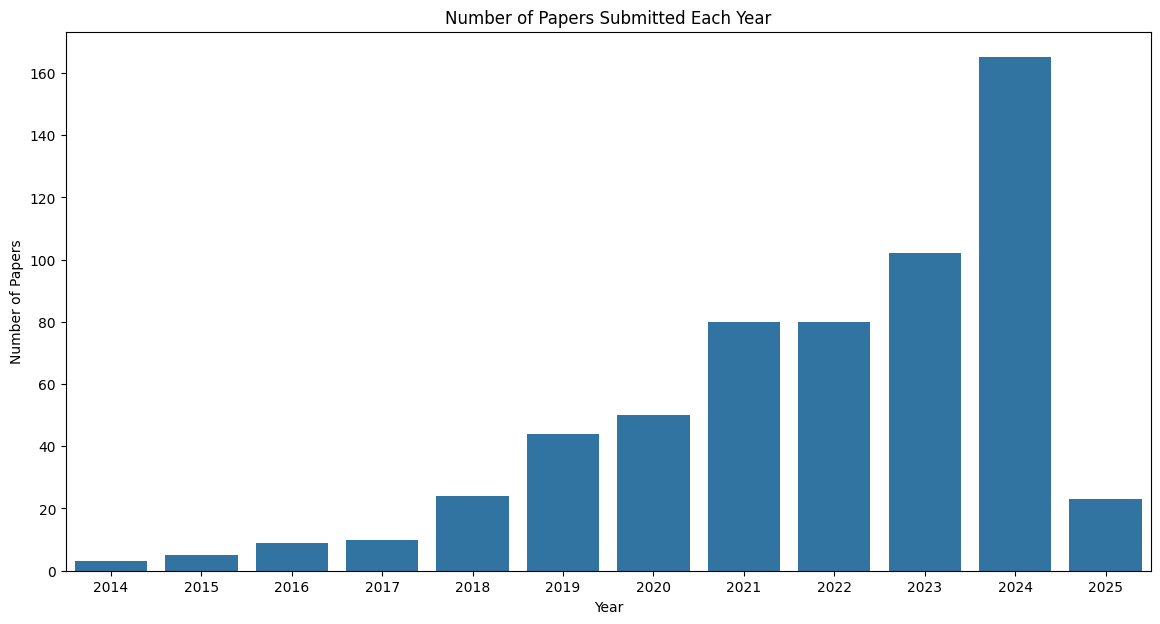

In [5]:
# Group by Year and count the number of papers
monthly_counts = df.groupby(['Year'], observed=False).size().reset_index(name='Counts')

# Create the plot
plt.figure(figsize=(14, 7))

sns.barplot(data=monthly_counts, x='Year', y='Counts')

plt.title('Number of Papers Submitted Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.savefig('paper_by_year.svg')
plt.show()

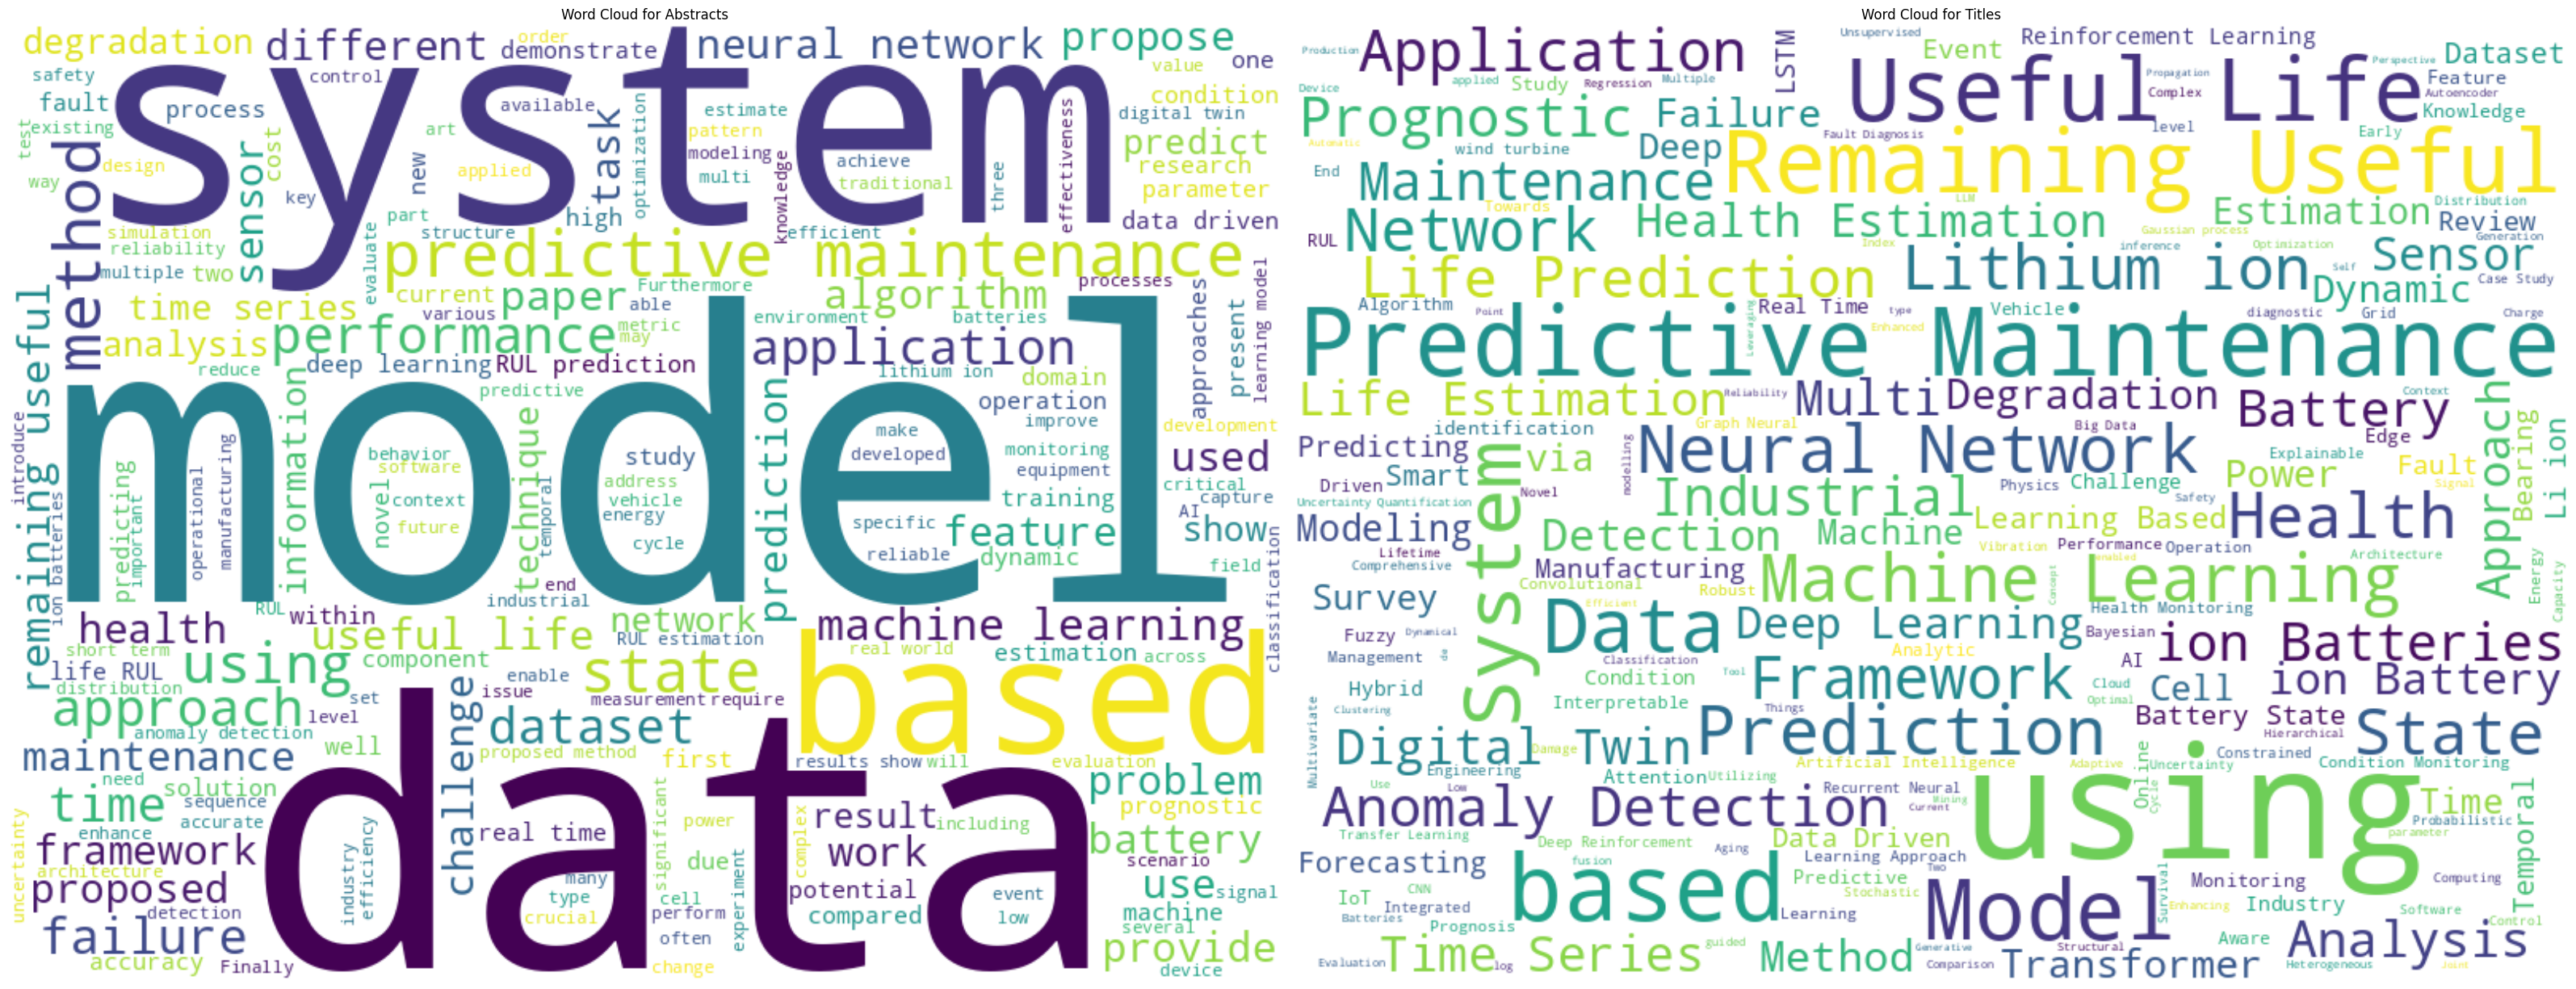

In [6]:
# Generate word cloud for abstracts
abstract_text = " ".join(df['Abstract'].dropna().tolist())
wordcloud_abstract = WordCloud(width=800, height=600, background_color='white').generate(abstract_text)

# Generate word cloud for titles
title_text = " ".join(df['Title'].dropna().tolist())
wordcloud_title = WordCloud(width=800, height=600, background_color='white').generate(title_text)

# Plot the word clouds
plt.figure(figsize=(32, 13))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_abstract, interpolation='bilinear')
plt.title('Word Cloud for Abstracts')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_title, interpolation='bilinear')
plt.title('Word Cloud for Titles')
plt.axis('off')

plt.tight_layout()
plt.savefig('word_clouds.png')
plt.show()

# README

In [7]:
# @title create read me file
def create_readme():
    year, month = None, None
    header = '# [Remaining Useful Life Prediction Papers](https://ramtinmoslemi.github.io/RUL-Papers/)\nA complete list of papers on **Remaining Useful Life (RUL) Prediction**, **State of Health (SOH) Prediction**, and **Predictive Maintenance (PdM)** submitted to arXiv over the past decade.\n\nYou can find the papers and their titles, abstracts, authors, links, and dates stored in [this csv file](https://github.com/RamtinMoslemi/RUL-Papers/blob/main/rul_papers.csv).\n\n'
    header += '## Paper Counts by Year\nNumber of papers submitted to arXiv by year.\n\n![yearly_papers](figures/paper_by_year.svg)\n\n'
    header += '## Word Clouds\nWord clouds of paper titles and abstracts.\n\n![word_clouds](figures/word_clouds.png)\n\n'
    header += '## Notebook\nYou can play with the notebook:\n\n'
    header += '[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RamtinMoslemi/RUL-Papers/blob/main/RUL_Papers.ipynb) [![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/RamtinMoslemi/RUL-Papers/main/RUL_Papers.ipynb)\n\n\n'
    with open('README.md', 'w', encoding='utf-8') as file:
        file.write(header)
        for i in range(len(df)):
            if df.iloc[i]['Year'] != year:
                year = df.iloc[i]['Year']
                file.write(f'# {year}\n')
            if df.iloc[i]['Month'] != month:
                month = df.iloc[i]['Month']
                file.write(f'## {month}\n')
            file.write(f"### [{df.iloc[i]['Title']}]({df.iloc[i]['Link']})\n\n")
            if len(df.iloc[i]['Authors'].split(',')) != 1:
                file.write(f"**Authors:**\n{df.iloc[i]['Authors']}\n\n")
            else:
                file.write(f"**Author:**\n{df.iloc[i]['Authors']}\n\n")
            file.write(f"**Abstract:**\n{df.iloc[i]['Abstract']}\n\n\n")

In [8]:
create_readme()